In [1]:
import os
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, when, count
!pip install pyspark

In [2]:
# Inisialisasi Spark Session
spark = SparkSession.builder \
    .appName("Online Payments Fraud Detection") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/08 12:27:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Path ke dataset (pastikan file CSV sudah di-upload ke environment Kaggle)
data_path = "/kaggle/input/online-payments-fraud-detection-dataset/PS_20174392719_1491204439457_log.csv"

# Baca dataset
df = spark.read.csv(data_path, header=True, inferSchema=True)

# Tampilkan informasi dasar dataset
print("Schema Dataset:")
df.printSchema()


Schema Dataset:
root
 |-- step: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- isFraud: integer (nullable = true)
 |-- isFlaggedFraud: integer (nullable = true)



In [4]:

print("\nJumlah Baris dan Kolom:")
print(f"Jumlah baris: {df.count()}, Jumlah kolom: {len(df.columns)}")


Jumlah Baris dan Kolom:


Jumlah baris: 6362620, Jumlah kolom: 11


In [5]:
print("\nMengecek Data Awal:")
df.show(5)



Mengecek Data Awal:
+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|  amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|   1| PAYMENT| 9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|
|   1| PAYMENT| 1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|
|   1|TRANSFER|   181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|
|   1|CASH_OUT|   181.0| C840083671|        181.0|           0.0|  C38997010|       21182.0|           0.0|      1|             0|
|   1| PAYMENT|11668.14|C2048537720|      41554.0|      29885.

In [6]:
print("\nDeskripsi Statistik:")
df.describe().show()


Deskripsi Statistik:


25/05/08 12:27:35 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+--------+------------------+-----------+-----------------+-----------------+-----------+------------------+------------------+--------------------+--------------------+
|summary|              step|    type|            amount|   nameOrig|    oldbalanceOrg|   newbalanceOrig|   nameDest|    oldbalanceDest|    newbalanceDest|             isFraud|      isFlaggedFraud|
+-------+------------------+--------+------------------+-----------+-----------------+-----------------+-----------+------------------+------------------+--------------------+--------------------+
|  count|           6362620| 6362620|           6362620|    6362620|          6362620|          6362620|    6362620|           6362620|           6362620|             6362620|             6362620|
|   mean|243.39724563151657|    NULL|179861.90354913412|       NULL|833883.1040744719|855113.6685785714|       NULL|1100701.6665196654|1224996.3982019408|0.001290820448180152| 2.51468734577894E-6|
| stddev|142.33

In [7]:
# Analisis distribusi kelas target (isFraud)
print("\nDistribusi Label Fraud:")
df.groupBy("isFraud").count().orderBy("isFraud").show()


Distribusi Label Fraud:


+-------+-------+
|isFraud|  count|
+-------+-------+
|      0|6354407|
|      1|   8213|
+-------+-------+



In [8]:
# Menghitung persentase fraud
fraud_percentage = df.filter(col("isFraud") == 1).count() / df.count() * 100
print(f"\nPersentase transaksi fraud: {fraud_percentage:.2f}%")



Persentase transaksi fraud: 0.13%


In [9]:
# Konversi kolom kategorikal menjadi numerik
categorical_columns = ["type"]
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df) for column in categorical_columns]

# Konversi oldbalance dan newbalance menjadi satu fitur (delta balance)
df = df.withColumn("balanceDiff", col("newbalanceOrig") - col("oldbalanceOrg"))
df = df.withColumn("destBalanceDiff", col("newbalanceDest") - col("oldbalanceDest"))

# Pilih kolom yang akan digunakan untuk pelatihan
feature_columns = ["step", "amount", "oldbalanceOrg", "newbalanceOrig", 
                  "oldbalanceDest", "newbalanceDest", "balanceDiff", "destBalanceDiff", "type_index"]

# Persiapkan data untuk modeling
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features_unscaled")
scaler = StandardScaler(inputCol="features_unscaled", outputCol="features", withStd=True, withMean=True)

# Split data menjadi training dan testing set
(train_data, test_data) = df.randomSplit([0.8, 0.2], seed=42)

print(f"\nJumlah data training: {train_data.count()}")
print(f"Jumlah data testing: {test_data.count()}")


Jumlah data training: 5089858


Jumlah data testing: 1272762


In [10]:
# Fungsi untuk melatih model dan evaluasi
def train_and_evaluate_model(classifier, model_name):
    # Buat pipeline
    pipeline = Pipeline(stages=indexers + [assembler, scaler, classifier])
    
    # Latih model
    model = pipeline.fit(train_data)
    
    # Prediksi
    predictions = model.transform(test_data)
    
    # Evaluasi
    binary_evaluator = BinaryClassificationEvaluator(labelCol="isFraud")
    auc = binary_evaluator.evaluate(predictions)
    
    multi_evaluator = MulticlassClassificationEvaluator(labelCol="isFraud", metricName="accuracy")
    accuracy = multi_evaluator.evaluate(predictions)
    
    multi_evaluator = MulticlassClassificationEvaluator(labelCol="isFraud", metricName="f1")
    f1 = multi_evaluator.evaluate(predictions)
    
    print(f"\n--- Hasil Evaluasi Model {model_name} ---")
    print(f"AUC: {auc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    return model, predictions, auc, accuracy, f1

In [11]:

# === 1. LOGISTIC REGRESSION ===
lr = LogisticRegression(labelCol="isFraud", featuresCol="features", maxIter=10, regParam=0.1)
lr_model, lr_predictions, lr_auc, lr_accuracy, lr_f1 = train_and_evaluate_model(lr, "Logistic Regression")

# === 2. RANDOM FOREST ===
rf = RandomForestClassifier(labelCol="isFraud", featuresCol="features", numTrees=100)
rf_model, rf_predictions, rf_auc, rf_accuracy, rf_f1 = train_and_evaluate_model(rf, "Random Forest")

# === 3. GRADIENT BOOSTED TREES ===
gbt = GBTClassifier(labelCol="isFraud", featuresCol="features", maxIter=10)
gbt_model, gbt_predictions, gbt_auc, gbt_accuracy, gbt_f1 = train_and_evaluate_model(gbt, "Gradient Boosted Trees")



--- Hasil Evaluasi Model Logistic Regression ---
AUC: 0.9561
Accuracy: 0.9987
F1 Score: 0.9981



--- Hasil Evaluasi Model Random Forest ---
AUC: 0.9838
Accuracy: 0.9994
F1 Score: 0.9993



--- Hasil Evaluasi Model Gradient Boosted Trees ---
AUC: 0.9943
Accuracy: 0.9995
F1 Score: 0.9995


In [12]:

# Perbandingan performa model
model_comparison = spark.createDataFrame([
    ("Logistic Regression", lr_auc, lr_accuracy, lr_f1),
    ("Random Forest", rf_auc, rf_accuracy, rf_f1),
    ("Gradient Boosted Trees", gbt_auc, gbt_accuracy, gbt_f1)
], ["Model", "AUC", "Accuracy", "F1 Score"])

print("\n--- Perbandingan Performa Model ---")
model_comparison.show()



--- Perbandingan Performa Model ---


+--------------------+------------------+------------------+------------------+
|               Model|               AUC|          Accuracy|          F1 Score|
+--------------------+------------------+------------------+------------------+
| Logistic Regression|0.9561096419506774|0.9987224634299264|0.9981360710430155|
|       Random Forest|0.9838211894975691| 0.999404444821577|0.9993192606776488|
|Gradient Boosted ...|0.9942764447691933|0.9995097276631452|0.9994569682434936|
+--------------------+------------------+------------------+------------------+



In [13]:
# Identifikasi model terbaik berdasarkan AUC
metrics_df = spark.createDataFrame([
    ("Logistic Regression", lr_auc),
    ("Random Forest", rf_auc),
    ("Gradient Boosted Trees", gbt_auc)
], ["Model", "AUC"])

# Tampilkan model terbaik
print("\n--- Identifikasi Model Terbaik ---")
best_model_info = metrics_df.orderBy(col("AUC").desc()).first()
best_model_name = best_model_info["Model"]
best_auc = best_model_info["AUC"]

# Tentukan best model dan metrics-nya
if best_model_name == "Logistic Regression":
    best_model_pipeline = lr_model
    best_predictions = lr_predictions
    best_accuracy = lr_accuracy
    best_f1 = lr_f1
elif best_model_name == "Random Forest":
    best_model_pipeline = rf_model
    best_predictions = rf_predictions
    best_accuracy = rf_accuracy
    best_f1 = rf_f1
else:  # Gradient Boosted Trees
    best_model_pipeline = gbt_model
    best_predictions = gbt_predictions
    best_accuracy = gbt_accuracy
    best_f1 = gbt_f1

print(f"\n--- Model Terbaik: {best_model_name} ---")
print(f"AUC: {best_auc:.4f}")
print(f"Accuracy: {best_accuracy:.4f}")
print(f"F1 Score: {best_f1:.4f}")


--- Identifikasi Model Terbaik ---

--- Model Terbaik: Gradient Boosted Trees ---
AUC: 0.9943
Accuracy: 0.9995
F1 Score: 0.9995


In [14]:
# Visualisasi metrik performa model (menggunakan pandas dan matplotlib)
models = ["Logistic Regression", "Random Forest", "Gradient Boosted Trees", f"Best Model ({best_model_name})"]
aucs = [lr_auc, rf_auc, gbt_auc, best_auc]
accuracies = [lr_accuracy, rf_accuracy, gbt_accuracy, best_accuracy]
f1_scores = [lr_f1, rf_f1, gbt_f1, best_f1]

metrics_df = pd.DataFrame({
    'Model': models,
    'AUC': aucs,
    'Accuracy': accuracies,
    'F1 Score': f1_scores
})

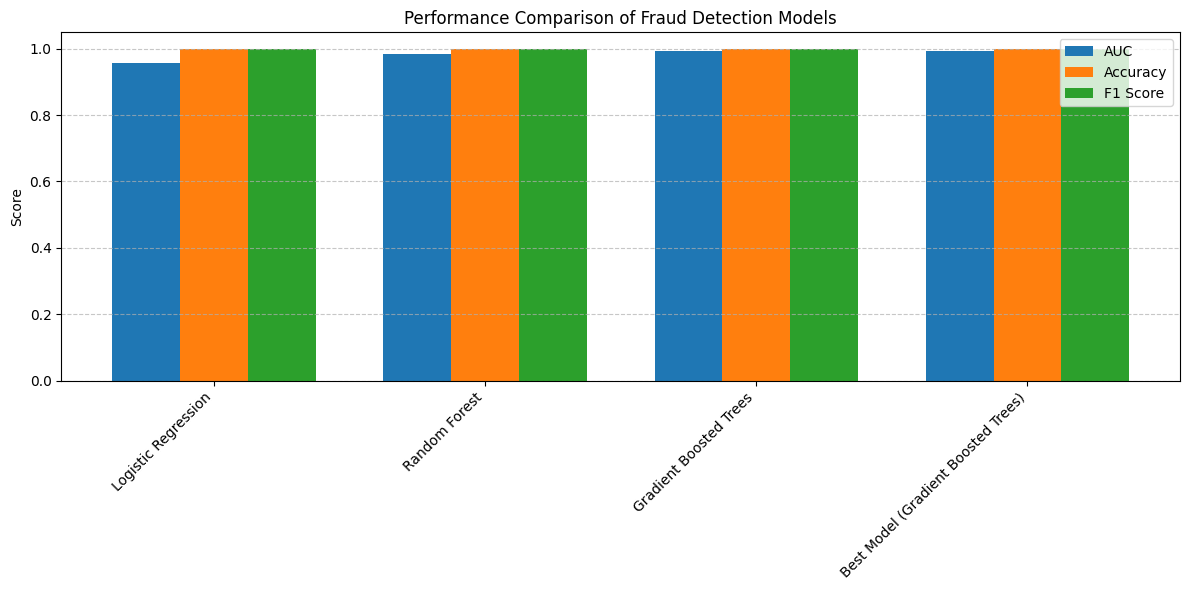

In [15]:
# Plot hasil
fig, ax = plt.subplots(figsize=(12, 6))
ind = np.arange(len(models))
width = 0.25

ax.bar(ind - width, aucs, width, label='AUC')
ax.bar(ind, accuracies, width, label='Accuracy')
ax.bar(ind + width, f1_scores, width, label='F1 Score')

ax.set_ylabel('Score')
ax.set_title('Performance Comparison of Fraud Detection Models')
ax.set_xticks(ind)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [16]:
# Simpan model terbaik
best_model_path = "best_fraud_detection_model"
best_model_pipeline.write().overwrite().save(best_model_path)
print(f"\nModel terbaik ({best_model_name}) telah disimpan di: {best_model_path}")


Model terbaik (Gradient Boosted Trees) telah disimpan di: best_fraud_detection_model


In [17]:
# Menutup spark session
spark.stop()